In [1]:
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install -q git+https://github.com/tensorflow/docs 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 496 kB of archives.
After this operation, 5,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Fetched 496 kB in 1s (473 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 145480 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Setting up python-opengl (3.1.0+dfsg-1) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 784 kB of 

In [2]:
# Import high level Keras API for tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Import library for querying for GPU information
from tensorflow.python.client import device_lib

# Import some utilities for gathering data from a test simulator
import gym
import numpy as np

# Import a progress bar implementation to help track training performance
import tqdm

# Import plotting utilties for tracking performance over time
from matplotlib import pyplot as plt

If using Google colab, be sure to enable hardware acceleration by following the instructions at https://colab.research.google.com/notebooks/gpu.ipynb

In [3]:
# Make sure that we are using GPUs for now. If we are not, then we should abort.
gpus = tf.config.list_physical_devices('GPU')
assert(len(gpus) > 0)

# TODO #6: It would be good to query for information about the GPU here so that
# we can make decisions which allow the code to be portable to devices with
# varying amounts of resources.
devices_info = device_lib.list_local_devices()
gpus_info = [device for device in devices_info if "GPU" in device.name]

Next we will define our standard implementation of PPO. For a good overview of how PPO works, there is an excellent resource at https://www.youtube.com/watch?v=5P7I-xPq8u8&t=1s&ab_channel=ArxivInsights

The pseudocode from the paper is below:

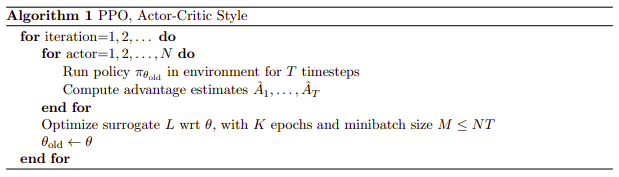

We start by creating a an Actor Critic model to build around. The tensorflow documentation has an implementation which has shared hidden layers, allowing for less computation.

https://www.tensorflow.org/tutorials/reinforcement_learning/actor_critic

In [4]:
# This code is largely from the tensorflow tutorial

class SimpleActorCritic(tf.keras.Model):
  """Combined actor-critic network."""

  def __init__(self, num_actions, num_hidden_units):
    """Initialize."""
    super().__init__()

    # Use two dense layers with RELU activations with separate outputs for the
    # actor and the critic
    self.common1 = layers.Dense(num_hidden_units, activation="relu")
    self.common2 = layers.Dense(num_hidden_units, activation="relu")

    # The actor is outputting logits for the different possible actions
    self.actor = layers.Dense(num_actions)

    # The critic is outputting an estimate of the value function
    self.critic = layers.Dense(1)

  def call(self, inputs):
    x1 = self.common1(inputs)
    x2 = self.common2(x1)
    return self.actor(x2), self.critic(x2)

Now we have our Actor Critic model which will return an action distribution that we can sample from for our policy as well as a value function estimate for eaach state. For PPO, however, the value function is not sufficient. We need the advantage function. The advantage function is tracking the *advantage* of taking one action over others in a particular state. One high-bias estimate of the advantage function takes in the Q value of that particular state action pair subtracting out the value of being in that state: $A^{\pi}(s_t,a_t) = Q^{\pi}(s_t,a_t)-V^{\pi}(s_t)$. One high-variance estimate of the advantage function takes in the monte carlo returns starting from timestep t: $A^{\pi}(s_t,a_t) = G_t-V^{\pi}(s_t)-V^{\pi}(s_t)$, where $G_t=\sum^{\inf}_{n=t}{\gamma}^{n-t}R_t$ where $R_t$ is the value returned by a reward function $R(s_t, a_t)$.

Our actor critic model is already giving us an estimate of the value function $\hat{V}^{\pi_{\theta}}(s_t)$, so now we need to try to choose which variant of advantage function we want to calculate! One approach is to use the lambda return, which is defined in section 12.1 of http://incompleteideas.net/book/RLbook2020.pdf. This estimator provides a formulation of the return which lets us balance between the high-bias Q-value (where $\lambda=0$) and the high-variance monte carlo return (where $\lambda=1$). It also lets us factor in the ability to deal with episodes which may be truncated, which in the case of PPO, we have. The formulation of this algorithm, known as TTD($\lambda$), requires care to ensure its memory requirements scale with the length of the rollouts.  This leaves us with the following equation:
$ G^{\lambda}_{t:t-k}=\hat{V}^{\pi_{\theta}}(s_t)+\sum^{t+k-1}_{n=t}(\gamma\lambda)^{n-t}\delta'_n$, where $\delta'_n=R_n+\gamma\hat{V}^{\pi_{\theta}}(s_{n+1})-\hat{V}^{\pi_{\theta}}(s_{n})$. We can calculate this moving backwards if we have the full rollout up to the end of our truncated episode, where the value of $k$ is determined by where the episode is truncated.

The authors of the original PPO paper used exactly this approach, and this estimate of the Advantage function is known as the generalized advantage estimate (GAE).

In [5]:
def get_expected_returns(values, rewards, final_value, dones, gamma, lambda_):
  """Compute expected returns per timestep."""
  # Get the number of rewards to accumulate for the epsiode
  n = tf.shape(rewards)[0]

  # Initialize values for accumulating the n-step returns
  nstep_return = 0
  returns = []

  # Implement the n-step truncated lambda return, which is described in equation
  # 12.10 of http://incompleteideas.net/book/RLbook2020.pdf
  # We implement the reverse view, which means working backwards from the end of
  # the episode towards the beginning.
  for t in tf.range(n - 1, -1, -1):

    # We need to take in the value of the next timestep that would have occurred
    # after we finished collecting data from our episode. That way, we have a
    # value of the state that would have occurred at t+1. This is particularly
    # important if the episode had not ended when we stopped gathering data.
    next_value = None
    if t == n - 1:
      next_value = tf.squeeze(final_value, 1)
    else:
      next_value = values[t + 1]

    # Calculate the n-step return delta. Again, we are using the reverse view,
    # so we build up the n-step trucated lambda returns backwards. There is a
    # good reference in PyTorch over at
    # https://github.com/higgsfield/RL-Adventure-2/blob/master/3.ppo.ipynb
    nstep_delta = rewards[t] + gamma * next_value * dones[t] - values[t]
    nstep_return = nstep_delta + gamma * lambda_ * dones[t] * nstep_return
    returns.insert(0, nstep_return + values[t])
  
  # Convert the list of per-timestep returns into a batched tensor
  returns = tf.expand_dims(returns, 0)

  return returns

Next, we will need to define an implementation of our loss function. The loss function defined in the paper is as follows:

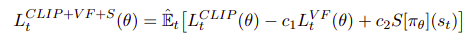

In layman's terms, this is basically saying to use a clipping objective, subtract off a scaled down loss of the critic (which in our case is taken from the advantage), and add in a scaled down bonus for an entropy term. We should cover each of these in detail.

$L^{CLIP}_t(\theta)=\hat{\mathbb{E}}_t[\min{(r_t(\theta)\hat{A}_t, \text{clip}(r_t(\theta),1-\epsilon,1+\epsilon))}]$ where $r_t(\theta)=\frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}$.

This deserves its own deep dive. The term $r_t(\theta)$ is roughly measuring how a current policy deviates from a previous iteration from the policy. If the two policies are identical, then this value will be exactly 1. The more that the new policy deviates from the old policy, the more different these values will be.

The goal is to try and limit deviations from the previous policy to the current policy by trying to limit how large of a step gets taken when the policy change appears to be heading in the right direction. By clipping the loss function in this way, the gradient that gets backpropogated will be conservative if the step taken was in a good direction, but it need not be conservative if the step taken was in a very poor direction from what was present in the original policy. The end result is that the training process tends to be more stable in the policy space.

The next two terms in our overall loss function were $-c_1L^{VF}_t(\theta)+c_2S[\pi_\theta](s_t)$. The values $c_1,c_2$ are hyperparameters which control the contribution of the other two terms. The term $L^{VF}_t(\theta)$ is simply our critic loss, which can be implemented using some standard regression loss formula (the paper uses MSE) for our advantage estimate. The value $S[\pi_\theta](s_t)$ is an entropy bonus, where we are essentially trying to maximize the entropy of the distribution of actions for a given state. The generic formula for entropy is $-\sum p(x)\log(x)$ for some probability distribution $p(x)$. In this case, our distribution is the policy in a given state, or a sample at some time step of our actor output.

In [6]:
def compute_ppo_loss(new_action_probs, actions, old_action_probs, values,
    advantages, returns, critic_loss_fn, c1, c2, epsilon):
  """Computes the proximal policy loss."""

  # Calculate the value of R for the actions taken in our rollouts.
  # The log of a product is the sum of the logs, so take the log of the
  # action probabilities, subtract what would have been the divisor from what
  # would have been the numerator, and then raise back up to the original
  # space. This has the same effect as dividing the two.
  new_action_log_probs = tf.math.log(new_action_probs)
  old_action_log_probs = tf.math.log(old_action_probs)
  r = tf.math.exp(new_action_log_probs - old_action_log_probs)

  # Calculate the entropy of our new distribution over actions,, which will be
  # used to encourage exploration in our actor implementation. Entropy is
  # calculated for each sample its distribution of actions, and then the sum of
  # entropy over the samples is taken for the loss function.
  entropy = -tf.math.reduce_sum(new_action_probs * new_action_log_probs, axis=1)
  entropy = tf.math.reduce_mean(entropy)

  # Compute the clipped value of r to ensure that we are not too aggressive in
  # updates in policy space which we think are going in the right direction. If
  # we are going in the wrong direction, feel free to be agressive in going
  # back. Perform this over all samples, and take the sum over the samples for
  # the loss function.
  clipped_r = tf.clip_by_value(r, 1 - epsilon, 1 + epsilon)
  actor_loss = tf.math.minimum(r, clipped_r) * advantages
  actor_loss = tf.math.reduce_mean(actor_loss)

  # We can use any loss function. Use huber loss, which is less sensitive to
  # outliers than RMSE and friends.
  critic_loss = critic_loss_fn(values, returns)

  # Take the negative of our loss because the algorithm is written up for
  # ascent, but our optimizer is performing descent
  ppo_loss = -(actor_loss - c1 * critic_loss + c2 * entropy)

  # Return the components of the the loss function for testing and debugging
  # purposes.
  return ppo_loss, actor_loss, critic_loss, entropy

We now have a loss function! We have our actor critic network for the forward and backward pass too. So we are ready to train once we have some data to train on. We can set up a minibatch-based training function in tensorflow.

We will gather new predictions for our action distribution and value functions, and we will replay the states from our policy-rollouts as data for our actor critic model. We will need to compare the probability of the selected action in the policy rollout for the new prediction against the old prediction, which is the only slightly tricky part here.

In [7]:
# Turn on graph execution mode with the tf.function decorator. If debugging is
# needed, it might be helpful to comment this decorator out.
@tf.function
def train_minibatch(mb_states, mb_actions, mb_actions_idx, mb_action_probs,
    mb_advantages, mb_returns, model, optimizer, critic_loss_fn, c1, c2,
    epsilon):
  """Runs a model training step."""

  # Track what we will need to calculate the gradients for with our ActorCritic
  # model.
  with tf.GradientTape() as tape:
    # Predict the new action logits and values given a minibatch of states
    new_action_logits, new_values = model(mb_states)

    # Calculate new action probabilities from the action logits
    new_action_prob_dists = tf.nn.softmax(new_action_logits)

    # Get the probability of the chosen actions in a minibatch being taken for
    # the new action probability distribution. Then, convert the result into
    # a batched tensor.
    new_action_probs = tf.gather_nd(new_action_prob_dists, mb_action_idx)
    new_action_probs = tf.expand_dims(new_action_probs, 1)

    # Calculate the loss values to update our network
    loss, L_a, L_c, S = compute_ppo_loss(new_action_probs, mb_actions,
        mb_action_probs, new_values, mb_advantages, mb_returns, critic_loss_fn,
        c1, c2, epsilon)

  # Compute the gradients from the loss
  grads = tape.gradient(loss, model.trainable_variables)

  # Apply the gradients to the actor critic model's parameters
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  return loss, L_a, L_c, S

At this point, we have our loss function implemented, we have our training loop implemented, and we have a way to get our advantage estimate. We need to set up some hyper-parameters for our test of PPO. Read the next code block to understand how these parameters are used.

In [8]:
################################################################################
# Set up the hyper-parameters
################################################################################

# How many episodes should we gather and train on before we stop training.
max_episodes = 5000

# When gathering training data, what is the maximum horizon we should look out
# over before truncating the episode.
max_steps_per_episode = 500

# Learning rate for optimizer
_learning_rate = 3e-5

# Discount factor for future rewards
gamma = 0.99

# Generalized advantage estimate trade-off (between 0 and 1)
lambda_ = 0.97

## PPO loss function parameters

# Critic loss scaling factor
c1 = 0.5

# Entropy bonus scaling factor
c2 = 1e-3

# Actor clipping value
epsilon = 0.1

# How many episodes should be gathered before an iteration of training
gather_episodes = 4

# How many training epochs should be run over the gathered data
num_epochs = 4

# TODO #6: provide constraints on this value based on the architecture
# How many training examples are part of a training minibatch
minibatch_size = 32

################################################################################
# Validate hyper-parameters that depend on one another
################################################################################

# Make sure that the number of training epochs is smaller
# than the number of time steps gathered. Since we don't have an actual
# number of timesteps gathered, just make a conservative estimate of 5 steps
# per episode
assert(num_epochs <= (gather_episodes * max_steps_per_episode))

At long last, we are ready to set up an environment and try things out! Let's start out with a simple Cartpole environment to see how we do.

We will iterate over PPO by first gathering a dataset by first running some number of episodes either to completion or truncated to some maximum number of steps per episode. Then, we will perform training of an actor critic model for some number of epochs over the gathered dataset. Then, we repeat the process, using the updated actor critic model to gather data from our latest policy.

Once again, it helps to look at the algorithm from the paper:

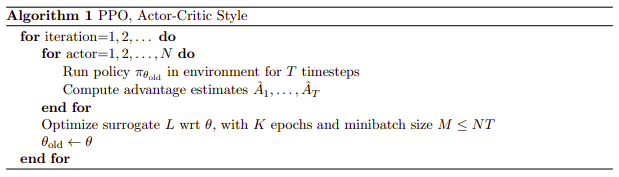

We will also gather episodic rewards and some parameters related to our loss function.

It is important to look at the loss not only for understanding how our agent is doing, but also to enable us to perform early stopping to avoid overfitting.

It is not critical to gather loss data over time, but this does help us perform analysis of how our training is going. For example, we will be able to look at things like whether training for our model appears to have diverged, or if some component of our loss appears to be specifically misbehaving relative to the others.

Finished step 834 with 4 episode rollouts and 4 training epochs:  67%|██████▋   | 834/1250 [20:38<10:17,  1.48s/it, episode_reward=[434.0, 436.0, 499.0, 499.0], max_running_reward=196, running_reward=195]


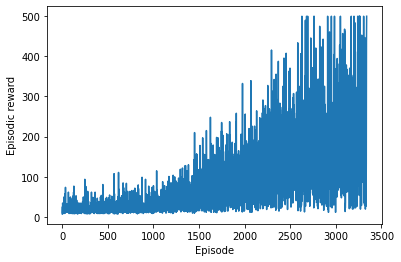

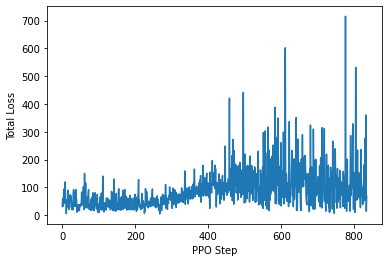

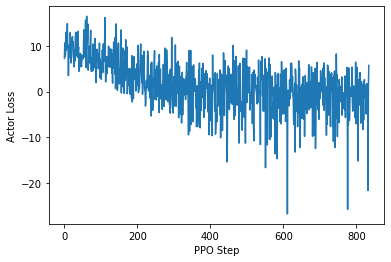

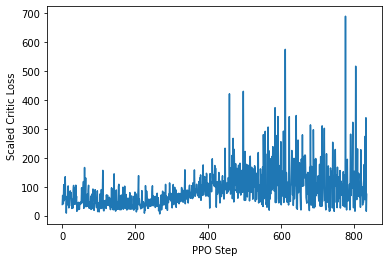

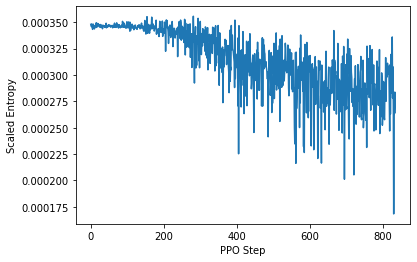


Solved at episode 834: average reward: 195.08!


In [9]:
# Create the environment
env = gym.make("CartPole-v1")

# Set seed for experiment reproducibility
seed = 12345
env.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

# Cartpole-v1 is considered solved if average reward is >= 195 over 100 
# consecutive trials
reward_threshold = 195
running_reward = 0

## Initialize the actor critic mode

# Use the Adam optimizer, which the paper claimed to help speed things up
optimizer = tf.keras.optimizers.Adam(learning_rate=_learning_rate)

# Use huber loss, which is more stable to outliers than RMSE.
critic_loss_fn = tf.keras.losses.MeanSquaredError()

# Create the network based on the desired number of action logits and the
# desired width of the hidden layers.
num_actions = env.action_space.n 
num_hidden_units = 128
model = SimpleActorCritic(num_actions, num_hidden_units)

# Initialize values for tracking rewards per episode for the purposes of early
# stopping and debugging
running_reward = 0
max_running_reward = 0
episode_rewards = []

# Track loss parameters for analysis and debugging
total_losses = []
actor_losses = []
critic_losses = []
entropy_terms = []

# Use a progress bar to track how far along we are in training.
with tqdm.trange(max_episodes // gather_episodes) as steps:
  for step in steps:
    # Reset training memory for this step of PPO.
    states = []
    actions = []
    action_probs = []
    values = []
    rewards = []
    dones = []

    # Gather data over some number of episodes
    for g in range(gather_episodes):
      # Reset the simulator and episode-tracking metadata
      state = env.reset()
      done = False
      episode_reward = 0
      epsiode_returns = []
      cur_ep_rewards = []
      cur_ep_dones = []

      for t in range(max_steps_per_episode):
        # Get a logits for actions and predicted value of the state
        action_logits, value = model(tf.expand_dims(state, 0))

        # Sample an action from the logits. This is coming from a batched
        # tensor, but it should only have a single value at index 0,0.
        action = tf.random.categorical(action_logits, 1)[0, 0]

        # Track the distribution and grad the probability for the action we took
        action_prob_dist = tf.nn.softmax(action_logits)
        action_prob = action_prob_dist[:, action]

        # Take a step in the simulator given our selected action
        state, reward, done, _ = env.step(action.numpy())

        # Keep track of values when the episode is not done by
        # 1 means the timestep counts
        done_f = float(1 - int(done))

        # Store step result in memory for the multi-episode data set
        states.append(state)
        actions.append(action)
        action_probs.append(action_prob)
        values.append(value)
        rewards.append(reward)
        dones.append(done_f)

        # Track cumulative rewards for this episode
        cur_ep_rewards.append(reward)
        cur_ep_dones.append(done_f)

        # If the simulator reports the episode is done, then stop gathering
        # data for this episode.
        if done:
          break

      # Keep track of some data related to rewards for early stopping,
      # debugging, and analysis purposes.
      for reward, done in zip(cur_ep_rewards, cur_ep_dones):
        episode_reward += (reward * done)

      episode_rewards.append(episode_reward)
      running_reward = episode_reward*0.01 + running_reward*.99
      max_running_reward = max(running_reward, max_running_reward)

    # Convert the data to tensors
    states = tf.squeeze(tf.convert_to_tensor(states))
    actions = tf.expand_dims(tf.squeeze(tf.convert_to_tensor(actions,
        dtype=tf.int32)), 1)
    action_probs = tf.expand_dims(tf.squeeze(
        tf.convert_to_tensor(action_probs)), 1)
    values = tf.expand_dims(tf.squeeze(tf.convert_to_tensor(values)), 1)
    rewards = tf.expand_dims(tf.squeeze(tf.convert_to_tensor(rewards)), 1)
    dones = tf.expand_dims(tf.squeeze(tf.convert_to_tensor(dones)), 1)

    # Get the value of the state one timestep into the future, which is needed
    # to calculate the estimate of the return at the last timestep.
    _, final_value = model(tf.expand_dims(states[-1], 0))

    # Calculate the returns for each timestep, and convert it into a batched
    # tensor.
    returns = get_expected_returns(values, rewards, final_value, dones, gamma,
        lambda_)
    returns = tf.expand_dims(tf.squeeze(tf.convert_to_tensor(returns)), 1)

    # Calculate the advantage from the estimated returns and the predicted
    # values for the model used to gather data.
    advantages = returns - values

    # Convert tensors to a Tensorflow dataset
    dataset = tf.data.Dataset.from_tensor_slices((states, actions, action_probs, advantages, returns))

    # Shuffle the data set and set it up to be used for our target number of
    # epochs for each step of PPO training.
    dataset = dataset.shuffle(max_steps_per_episode * minibatch_size).repeat(num_epochs).batch(minibatch_size)

    # Train over the gathered data for some number of iterations
    loss, L_a, L_c, S = None, None, None, None
    for batch in dataset:
      mb_states = batch[0]
      mb_actions = batch[1]
      mb_action_probs = batch[2]
      mb_advantages = batch[3]
      mb_returns = batch[4]
      mb_action_idx = tf.transpose(tf.stack([tf.range(mb_actions.shape[0]),
          tf.squeeze(mb_actions, 1)]))
      loss, L_a, L_c, S = train_minibatch(mb_states, mb_actions, mb_action_idx,
          mb_action_probs, mb_advantages, mb_returns, model, optimizer,
          critic_loss_fn, c1, c2, epsilon)

    # Keep track of the loss for each training step
    total_losses.append(loss)
    actor_losses.append(L_a)
    critic_losses.append(c1 * L_c)
    entropy_terms.append(c2 * S)

    # Update the progress bar for each PPO training step
    steps.set_description(f'Finished step {step} with {gather_episodes} episode rollouts and {num_epochs} training epochs')
    steps.set_postfix(episode_reward=episode_rewards[-gather_episodes:], running_reward=running_reward, max_running_reward=max_running_reward)

    # Perform early stopping if our running reward is better than our threshold
    if running_reward > reward_threshold:  
        break

# Plot the episodic reward over time. It should go up if we are doing things 
# properly!
plt.plot(np.array(episode_rewards))
plt.xlabel("Episode")
plt.ylabel("Episodic reward")
plt.show()

# Track the total loss of the PPO function. This is useful to help tell if our
# model is diverging due to an improper set of hyper-parameters.
plt.plot(np.array(total_losses))
plt.xlabel("PPO Step")
plt.ylabel("Total Loss")
plt.show()

# Track the contribution of the actor loss component to the loss function. This
# is only for debugging purposes.
plt.plot(np.array(actor_losses))
plt.xlabel("PPO Step")
plt.ylabel("Actor Loss")
plt.show()

# Track the contribution of the critic loss component to the loss function. This
# is only for debugging purposes.
plt.plot(np.array(critic_losses))
plt.xlabel("PPO Step")
plt.ylabel("Scaled Critic Loss")
plt.show()

# Track the contribution of the entropy component to the loss function. This
# is only for debugging purposes.
plt.plot(np.array(entropy_terms))
plt.xlabel("PPO Step")
plt.ylabel("Scaled Entropy")
plt.show()

# Print out a final summary once training is done.
if running_reward > reward_threshold:
  print(f'\nSolved at episode {step}: average reward: {running_reward:.2f}!')
else:
  print(f'\nUnable to solve after {step} episodes. Average reward: {running_reward:.2f}')

While we are setting a deterministic random seed, the training process does not always converge. This is possibly due to accumulated floating point errors or stochasticity of operations performed in the GPU.

The following blocks allow us to visualize how our PPO-trained policy performs.

In [12]:
# Render an episode and save as a GIF file

from IPython import display as ipythondisplay
from PIL import Image
from pyvirtualdisplay import Display


display = Display(visible=0, size=(400, 300))
display.start()


def render_episode(env: gym.Env, model: tf.keras.Model, max_steps: int): 
  screen = env.render(mode='rgb_array')
  im = Image.fromarray(screen)

  images = [im]

  state = env.reset()
  for i in range(1, max_steps + 1):
    action_probs, _ = model(tf.expand_dims(state, 0))
    action = np.argmax(np.squeeze(action_probs))

    state, _, done, _ = env.step(action)
    state = tf.constant(state, dtype=tf.float32)

    # Render screen every 10 steps
    if i % 10 == 0:
      screen = env.render(mode='rgb_array')
      images.append(Image.fromarray(screen))

    if done:
      break

  return images


# Save GIF image
images = render_episode(env, model, 5000)
image_file = 'cartpole-v1.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_file, save_all=True, append_images=images[1:], loop=0, duration=1)


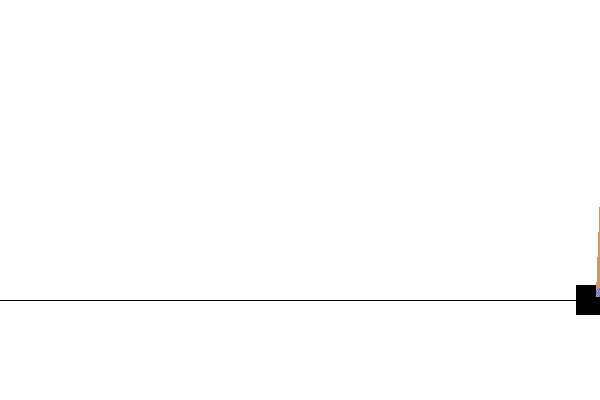

In [13]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(image_file)